#**Installing Required Libraries**

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 904.3/904.3 kB 41.3 MB/s eta 0:00:00


In [ ]:
!pip install --upgrade sympy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 83.9 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.1
    Uninstalling sympy-1.13.1:
      Successfully uninstalled sympy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu121 requires sympy==1.13.1; python_version >= "3.9", but you have sympy 1.13.3 which is incompatible.


In [ ]:
!pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 88.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.4 MB/s eta 0:00:00


In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


#**Checking the GPU Connectivity**

In [ ]:
import torch
print("CUDA Available:", torch.cuda.is_available())
print("Device Count:", torch.cuda.device_count())
print("Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")


CUDA Available: True
Device Count: 1
Device Name: Tesla T4


##**Data was stored in Google drive, so in this step we will be loading the drive.**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**Visualization and loading the data**

In [ ]:
import pandas as pd

# Load the detection data CSV
detection_data = pd.read_csv('/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/Detection/Licplatesdetection_train.csv')

# Verify the data is loaded correctly
detection_data.head()

,img_id,ymin,xmin,ymax,xmax
0,1.jpg,276,94,326,169
1,10.jpg,311,395,344,444
2,100.jpg,406,263,450,434
3,101.jpg,283,363,315,494
4,102.jpg,139,42,280,222


In [ ]:
detection_data.isnull().sum()

,0
img_id,0
ymin,0
xmin,0
ymax,0
xmax,0


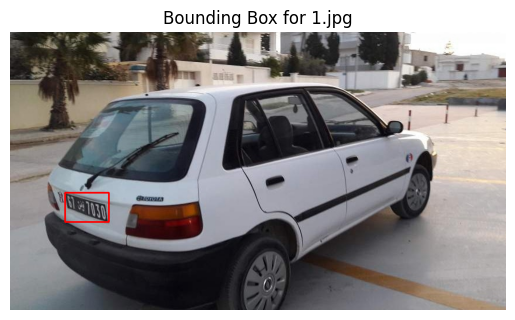

In [ ]:
import cv2
import matplotlib.pyplot as plt

def visualize_detection(image_dir, annotation_df, image_name):
    # Load image
    img_path = f"{image_dir}/{image_name}"
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Get bounding box annotations
    bbox = annotation_df[annotation_df['img_id'] == image_name].iloc[0]
    ymin, xmin, ymax, xmax = bbox[['ymin', 'xmin', 'ymax', 'xmax']]

    # Draw bounding box
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)

    # Display image
    plt.imshow(img)
    plt.title(f"Bounding Box for {image_name}")
    plt.axis('off')
    plt.show()

# Visualize a sample detection
visualize_detection("/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/Detection/images", detection_data, "1.jpg")

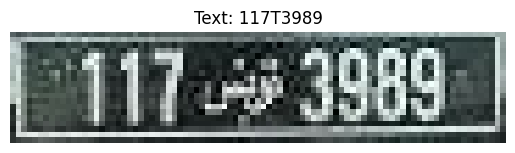

In [ ]:
def visualize_recognition(image_dir, annotation_df, image_name):
    # Load image
    img_path = f"{image_dir}/{image_name}"
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Get text annotation
    text = annotation_df[annotation_df['img_id'] == image_name].iloc[0]['text']

    # Display image and text
    plt.imshow(img)
    plt.title(f"Text: {text}")
    plt.axis('off')
    plt.show()

# Visualize a sample recognition
visualize_recognition("/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/Recognition/images", recognition_data, "0.jpg")

#**Task 1: Detection**

###**Creating Yolo Annotation using the dataset**

In [ ]:
# Prepare annotations in YOLO format with normalization
def prepare_yolo_annotations(df, img_dir, save_dir):
    import os
    os.makedirs(save_dir, exist_ok=True)

    for _, row in df.iterrows():
        # Get image dimensions
        img_path = os.path.join(img_dir, row['img_id'])
        from PIL import Image
        with Image.open(img_path) as img:
            img_width, img_height = img.size

        # Calculate normalized values
        width = (row['xmax'] - row['xmin']) / img_width
        height = (row['ymax'] - row['ymin']) / img_height
        x_center = (row['xmin'] + (row['xmax'] - row['xmin']) / 2) / img_width
        y_center = (row['ymin'] + (row['ymax'] - row['ymin']) / 2) / img_height

        # Prepare annotation in YOLO format
        annotation = f"0 {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n"

        # Save annotation to a .txt file
        file_path = os.path.join(save_dir, row['img_id'].replace(".jpg", ".txt"))
        with open(file_path, "w") as f:
            f.write(annotation)

In [ ]:
#Create the labels for all the detection images
prepare_yolo_annotations(detection_data, "/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/Detection/images", "/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/Detection/labels")

#**Split the Detection Dataset into train and validation set**

In [ ]:
#Split the training data into train and validation set:

import os
import random
import shutil
from sklearn.model_selection import train_test_split

def split_data(images_path, labels_path, output_path, val_size=0.2, random_state=42):
    """Splits image and label data into training and validation sets.

    Args:
        images_path: Path to the directory containing images.
        labels_path: Path to the directory containing label files (e.g., YOLO format).
        output_path: Path to the output directory where train and val folders will be created.
        val_size: Fraction of data to use for validation (e.g., 0.2 for 20%).
        random_state: Seed for the random number generator for reproducibility.
    """

    image_files = [f for f in os.listdir(images_path) if os.path.isfile(os.path.join(images_path, f))]
    label_files = [f for f in os.listdir(labels_path) if os.path.isfile(os.path.join(labels_path, f))]

    # Ensure corresponding image and label files exist
    image_names = [os.path.splitext(f)[0] for f in image_files]
    label_names = [os.path.splitext(f)[0] for f in label_files]

    common_files = list(set(image_names) & set(label_names))
    if len(common_files) != len(image_names) or len(common_files) != len(label_names) :
        raise Exception("There is a mismatch between image and label files. Check if all images have a corresponding label and vice versa")

    image_files = [f + os.path.splitext(image_files[0])[1] for f in common_files]
    label_files = [f + os.path.splitext(label_files[0])[1] for f in common_files]

    # Split the file names
    train_files, val_files = train_test_split(common_files, test_size=val_size, random_state=random_state)

    #Create output directories
    os.makedirs(os.path.join(output_path, "train", "images"), exist_ok=True)
    os.makedirs(os.path.join(output_path, "train", "labels"), exist_ok=True)
    os.makedirs(os.path.join(output_path, "val", "images"), exist_ok=True)
    os.makedirs(os.path.join(output_path, "val", "labels"), exist_ok=True)

    # Copy files to the appropriate directories
    for filename in train_files:
        shutil.copy(os.path.join(images_path, filename + os.path.splitext(image_files[0])[1]), os.path.join(output_path, "train", "images"))
        shutil.copy(os.path.join(labels_path, filename + os.path.splitext(label_files[0])[1]), os.path.join(output_path, "train", "labels"))

    for filename in val_files:
        shutil.copy(os.path.join(images_path, filename + os.path.splitext(image_files[0])[1]), os.path.join(output_path, "val", "images"))
        shutil.copy(os.path.join(labels_path, filename + os.path.splitext(label_files[0])[1]), os.path.join(output_path, "val", "labels"))

In [ ]:
images_path = "/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/Detection/images"  # image directory
labels_path = "/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/Detection/labels"  # label directory
output_path = "/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/detection_splits" # The output directory where the folders will be created
split_data(images_path, labels_path, output_path, val_size=0.2)
print("Data Splitted Successfully")

Data Splitted Successfully


#**Creating YAML file for Yolov11 training**

In [ ]:
detection_yaml_content = f"""
path: /content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/detection_splits
train: train/images
val: val/images

nc: 1
names: ['car_number_plate']
"""

# Write the detection YAML file
with open('detection_annotations.yaml', 'w') as detection_file:
    detection_file.write(detection_yaml_content)

print("Detection YAML file created!")

Detection YAML file created!


In [ ]:
!cat detection_annotations.yaml


path: /content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/detection_splits
train: train/images
val: val/images

nc: 1
names: ['car_number_plate']


#**Training the Yolo V11 model for detection task**

In [ ]:
from ultralytics import YOLO

# Load a model
model = YOLO("yolo11n.pt")

In [ ]:
# Train the model
train_results = model.train(
    data="/content/detection_annotations.yaml",
    epochs=10, # training on 10 epochs
    imgsz=640, # training image size
    device="cuda:0",  # device to run on, i.e. device=0
)

Ultralytics 8.3.55 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/detection_annotations.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda:0, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True

train: Scanning /content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/detection_splits/train/labels.cache... 867 images, 0 backgrounds, 0 corrupt: 100%|██████████| 867/867 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/detection_splits/val/labels.cache... 327 images, 0 backgrounds, 0 corrupt: 100%|██████████| 327/327 [00:00<?, ?it/s]


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.44G      1.202      3.088      1.087          3        640: 100%|██████████| 55/55 [00:27<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.23it/s]

                   all        327        327      0.906     0.0589      0.861      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.36G      1.205      2.034      1.057          3        640: 100%|██████████| 55/55 [00:23<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.73it/s]


                   all        327        327      0.953      0.924      0.966      0.639

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.37G      1.167      1.577      1.087          3        640: 100%|██████████| 55/55 [00:21<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.95it/s]


                   all        327        327      0.959      0.908      0.976      0.657

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.37G      1.109      1.266      1.023          3        640: 100%|██████████| 55/55 [00:20<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.94it/s]


                   all        327        327      0.939      0.942       0.97      0.693

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.38G      1.092      1.073      1.009          3        640: 100%|██████████| 55/55 [00:21<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.18it/s]


                   all        327        327      0.983      0.963      0.992      0.689

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.37G       1.02     0.9116     0.9735          3        640: 100%|██████████| 55/55 [00:21<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.61it/s]

                   all        327        327      0.987       0.96      0.992      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.36G     0.9768     0.8157     0.9605          3        640: 100%|██████████| 55/55 [00:23<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.33it/s]


                   all        327        327      0.985      0.984      0.995      0.747

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.37G     0.9357     0.7336     0.9501          3        640: 100%|██████████| 55/55 [00:21<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.39it/s]

                   all        327        327      0.997      0.994      0.995      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.38G     0.9004     0.6762     0.9455          3        640: 100%|██████████| 55/55 [00:23<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.12it/s]


                   all        327        327      0.985      0.999      0.995      0.767

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.37G     0.8659     0.6249     0.9036          3        640: 100%|██████████| 55/55 [00:24<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  2.18it/s]


                   all        327        327      0.994      0.996      0.995      0.781

10 epochs completed in 0.082 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 5.4MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 5.4MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics 8.3.55 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.54it/s]


                   all        327        327      0.994      0.996      0.995       0.78
Speed: 0.2ms preprocess, 2.9ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/detect/train3


In [ ]:
# Evaluate model performance on the validation set
metrics = model.val()

Ultralytics 8.3.55 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/detection_splits/val/labels.cache... 327 images, 0 backgrounds, 0 corrupt: 100%|██████████| 327/327 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.45it/s]


                   all        327        327      0.991          1      0.995      0.778
Speed: 0.3ms preprocess, 5.8ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/train32



image 1/210 /content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/test/test/1000.jpg: 448x640 1 car_number_plate, 10.5ms
image 2/210 /content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/test/test/1001.jpg: 640x384 1 car_number_plate, 11.3ms
image 3/210 /content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/test/test/1002.jpg: 640x480 1 car_number_plate, 24.5ms
image 4/210 /content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/test/test/1003.jpg: 384x640 1 car_number_plate, 10.3ms
image 5/210 /content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/test/test/1004.jpg: 640x384 1 car_number_plate, 9.9ms
image 6/210 /content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/test/test/1005.jpg: 640x384 1 car_number_plate, 11.4ms
image 7/210 /content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/test/test/1006.jpg: 640x480 1 car_number_plate, 9.5ms
image 8/210 /content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/test/test/1007.jpg: 640x384 1 car_number_plate, 9.9ms
image 9/210 /content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/test/test/100

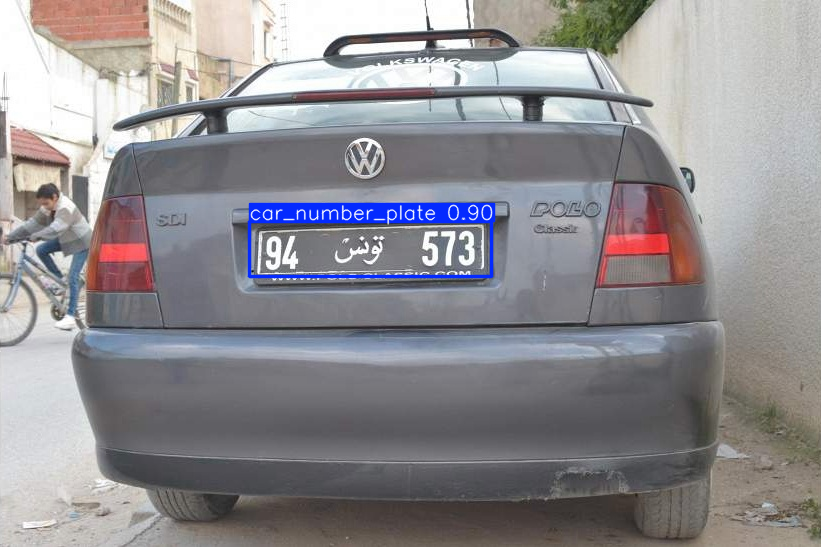

In [ ]:
# Perform object detection on an image
results = model("/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/test/test")
results[0].show()

In [ ]:
# Export the model to ONNX format
path = model.export(format="onnx")  # return path to exported model

Ultralytics 8.3.55 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.00GHz)

PyTorch: starting from 'runs/detect/train3/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (5.2 MB)

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.45...
ONNX: export success ✅ 1.7s, saved as 'runs/detect/train3/weights/best.onnx' (10.1 MB)

Export complete (2.0s)
Results saved to /content/runs/detect/train3/weights
Predict:         yolo predict task=detect model=runs/detect/train3/weights/best.onnx imgsz=640  
Validate:        yolo val task=detect model=runs/detect/train3/weights/best.onnx imgsz=640 data=/content/detection_annotations.yaml  
Visualize:       https://netron.app


#**Task 2: Recognition**

In [ ]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, LSTM, TimeDistributed, Bidirectional
from tensorflow.keras.layers import GRU, BatchNormalization, Reshape, Lambda
import tensorflow as tf

##**Loading the data for the recognition task**

In [ ]:
recognition_data = pd.read_csv('/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/Recognition/Licplatesrecognition_train.csv')

# Verify the data is loaded correctly
recognition_data.head()

,img_id,text
0,0.jpg,117T3989
1,1.jpg,128T8086
2,10.jpg,94T3458
3,100.jpg,133T6719
4,101.jpg,68T5979


In [ ]:
recognition_data.isnull().sum()

,0
img_id,0
text,0


#**Data Preprocessing for CRNN model for OCR.**

In [ ]:
# Image and text directories
image_dir = "/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/Recognition/images"

In [ ]:
# Character set and mapping
characters = set(''.join(recognition_data['text'].values))
char_to_idx = {char: idx + 1 for idx, char in enumerate(characters)}
idx_to_char = {idx: char for char, idx in char_to_idx.items()}
char_to_idx['<PAD>'] = 0  # Add padding token

def encode_text(text, max_length=16):
    # Encode text as integers and pad
    return pad_sequences([[char_to_idx[char] for char in text]], maxlen=max_length, padding='post', value=0)[0]

def decode_text(encoded_text):
    # Decode integers back to text
    return ''.join(idx_to_char[idx] for idx in encoded_text if idx > 0)

In [ ]:
def preprocess_image(img_path, target_size=(128, 32)):
    """
    Preprocess image with explicit shape handling
    Returns: image with shape (height, width, channels) = (32, 128, 1)
    """
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Could not read image at {img_path}")

    # Resize with width=128, height=32
    img = cv2.resize(img, (target_size[0], target_size[1]))  # (32, 128)

    # Add channel dimension and normalize
    img = np.expand_dims(img, axis=-1)  # (32, 128, 1)
    img = img / 255.0

    return img

In [ ]:
def create_dataset(data, img_dir, max_length=16):
    """
    Create dataset with explicit shape handling
    Returns: images with shape (n_samples, height, width, channels)
    """
    images, labels = [], []
    for _, row in data.iterrows():
        img_path = os.path.join(img_dir, row['img_id'])
        text = row['text']
        try:
            img = preprocess_image(img_path)  # Shape: (32, 128, 1)
            images.append(img)
            labels.append(encode_text(text, max_length=max_length))
        except Exception as e:
            print(f"Error processing {img_path}: {str(e)}")
            continue

    # Stack images with correct shape
    images = np.stack(images, axis=0)  # Shape: (n_samples, 32, 128, 1)
    return images, np.array(labels)

In [ ]:
def build_model(input_shape=(32, 128, 1), num_classes=None):
    """
    Build model with correct input shape handling
    input_shape should be (height, width, channels) = (32, 128, 1)
    """
    if num_classes is None:
        raise ValueError("num_classes must be specified")

    # Input layer with correct shape
    inputs = Input(shape=input_shape, name='image_input')

    # CNN Feature Extraction
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Get shape after convolutions
    _, new_height, new_width, channels = x.shape

    # Reshape for sequence processing - preserve width as sequence length
    x = Reshape((new_width, new_height * channels))(x)

    # RNN layers
    x = Bidirectional(LSTM(256, return_sequences=True, dropout=0.2))(x)
    x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.2))(x)

    # Output layer
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs, name='license_plate_recognition')

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

model.summary()

Model: "license_plate_recognition"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)             │ (None, 32, 128, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 32, 128, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 16, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 16, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 8, 32, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 8, 32, 128)          │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 4, 16, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_8 (Reshape)                  │ (None, 16, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_16 (Bidirectional)     │ (None, 16, 512)             │       1,574,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_17 (Bidirectional)     │ (None, 16, 256)             │         656,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 16, 13)              │           3,341 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,981,929 (26.63 MB)

 Trainable params: 2,327,309 (8.88 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,654,620 (17.76 MB)

In [ ]:
# Load and split data
train_data, val_data = train_test_split(recognition_data, test_size=0.2, random_state=42)

In [ ]:
# Create datasets with correct shapes
X_train, y_train = create_dataset(train_data, image_dir)
X_val, y_val = create_dataset(val_data, image_dir)

In [ ]:
# Verify shapes
print(f"X_train shape: {X_train.shape}")  # Should be (n_samples, 32, 128, 1)
print(f"y_train shape: {y_train.shape}")  # Should be (n_samples, max_length)

X_train shape: (720, 32, 128, 1)
y_train shape: (720, 16)


In [ ]:
# Prepare labels
y_train_sparse = y_train[:, :, np.newaxis]
y_val_sparse = y_val[:, :, np.newaxis]

#**Training the CRNN model for OCR**

In [ ]:
# Create and train model with correct input shape
model = build_model(input_shape=(32, 128, 1), num_classes=num_classes)
history = model.fit(
    x=X_train,
    y=y_train_sparse,
    validation_data=(X_val, y_val_sparse),
    batch_size=32,
    epochs=150
)

Epoch 1/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.4913 - loss: 1.7172 - val_accuracy: 0.6375 - val_loss: 1.1375
Epoch 2/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.6396 - loss: 1.1309 - val_accuracy: 0.6528 - val_loss: 1.0854
Epoch 3/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6508 - loss: 1.0846 - val_accuracy: 0.6521 - val_loss: 1.0549
Epoch 4/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6526 - loss: 1.0577 - val_accuracy: 0.6531 - val_loss: 1.0446
Epoch 5/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6591 - loss: 1.0400 - val_accuracy: 0.6635 - val_loss: 1.0274
Epoch 6/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6566 - loss: 1.0302 - val_accuracy: 0.6604 - val_loss: 1.0151
Epoch 7/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6584 - loss: 1.0188 - val_accuracy: 0.6618 - val_loss: 1.0011
Epoch 8/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6553 - loss: 1.0112 - val_accuracy: 0.

In [ ]:
# Evaluate on validation data
loss, accuracy = model.evaluate(X_val, y_val_sparse)
print(f"Validation Loss: {loss}, Validation Accuracy: {accuracy}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7221 - loss: 1.2978 
Validation Loss: 1.2603590488433838, Validation Accuracy: 0.7298611402511597


In [ ]:
model.save('license_plate_recognition_model.h5')
print("Model saved successfully!")

Model saved successfully!


In [ ]:
def predict_text(model, image_path):
    img = preprocess_image(image_path)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    prediction = model.predict(img)
    predicted_text = decode_text(np.argmax(prediction, axis=-1)[0])
    return predicted_text

# Test on a sample image
sample_image_path = "/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/Recognition/images/0.jpg"
predicted_text = predict_text(model, sample_image_path)
print(f"Predicted Text: {predicted_text}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted Text: 117T3989


#**Integration of Detection and Recognition Models**

**Detection and Recoginition models are combined using a pipeline method, we have used the approach that, we will be first detecting the number plate location using the car image given in the test set. After that the image will be cropped and will be sent to the recognition model, using the cropped image the recognition task will be performed and the results will be saved.**

In [ ]:
import os
import cv2
import numpy as np
from ultralytics import YOLO  # Detection model
from tensorflow.keras.models import load_model  # Recognition model
import tensorflow as tf
from PIL import Image

# Load detection model
detection_model = YOLO("/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/runs/detect/train3/weights/best.pt")

# Load recognition model
recognition_model = load_model("/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/license_plate_recognition_model.h5")

def preprocess_plate_image(cropped_image):
    """
    Preprocess the cropped number plate image for better recognition results.
    Steps include grayscale conversion, resizing, noise removal, and contrast enhancement.
    """
    # Convert to grayscale
    gray_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)

    # Resize the image to a fixed size expected by the recognition model
    resized_image = cv2.resize(gray_image, (128, 32), interpolation=cv2.INTER_AREA)

    # Apply GaussianBlur to reduce noise
    denoised_image = cv2.GaussianBlur(resized_image, (5, 5), 0)

    # Apply Adaptive Histogram Equalization for contrast improvement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(denoised_image)

    # Binarization: Convert to binary (black and white) using adaptive thresholding
    binary_image = cv2.adaptiveThreshold(
        enhanced_image,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,
        11,
        2
    )

    # Convert back to RGB for compatibility with models expecting color input
    preprocessed_image = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2RGB)

    return preprocessed_image

# Function to decode recognition output
def decode_text(predictions, char_list):
    """
    Decodes the output of the recognition model.
    Args:
    - predictions: NumPy array of shape (batch_size, num_classes) with probabilities for each class.
    - char_list: List of characters corresponding to the output classes.

    Returns:
    - Decoded text as a string.
    """
    decoded = ""
    indices = predictions.flatten().tolist()  # Flatten and convert to list if needed
    for idx in indices:
        if idx < len(char_list) and char_list[idx] != "<PAD>":
            decoded += char_list[idx]
    return decoded

# Pipeline: Detection and Recognition
def detect_and_recognize(test_folder, char_list):
    results = {}

    for image_file in os.listdir(test_folder):
        if image_file.endswith(('.png', '.jpg', '.jpeg')):
            # Load image
            image_path = os.path.join(test_folder, image_file)
            image = cv2.imread(image_path)
            original_image = image.copy()  # Keep a copy for visualization

            # Detect number plates
            results_detection = detection_model.predict(image)

            # Process detections
            for result in results_detection:
                if result.boxes.shape[0] > 0:  # Ensure there's a detection
                    for box in result.boxes:
                        x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())

                        # Crop number plate region
                        number_plate = image[y1:y2, x1:x2]

                        # Ensure the cropped region is valid
                        if number_plate.size > 0:
                            # Preprocess the cropped image
                            processed_plate = preprocess_recognition_image(number_plate)

                            # Recognize text
                            prediction = recognition_model.predict(processed_plate)
                            class_indices = prediction.argmax(axis=-1)
                            decoded_text = decode_text(class_indices, char_list)

                            # Save results
                            results[image_file] = decoded_text

                            # Draw bounding box and label on original image
                            cv2.rectangle(original_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
                            cv2.putText(original_image, decoded_text, (x1, y1 - 10),
                                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

            # Save the processed image with bounding box and recognized text
            output_image_path = os.path.join(test_folder, f"output_{image_file}")
            cv2.imwrite(output_image_path, original_image)

    return results

# Define the character list for decoding recognition model outputs
char_list = list("0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ") + ["<PAD>"]

# Run the pipeline
test_folder = "/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/test/test"  # Path to your test folder with car images
output_results = detect_and_recognize(test_folder, char_list)

# Print results
for image, number_plate_text in output_results.items():
    print(f"Image: {image} | Number Plate: {number_plate_text}")



0: 640x480 1 car_number_plate, 168.4ms
Speed: 3.8ms preprocess, 168.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step

0: 480x640 1 car_number_plate, 149.5ms
Speed: 5.2ms preprocess, 149.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

0: 640x480 1 car_number_plate, 165.6ms
Speed: 4.8ms preprocess, 165.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

0: 480x640 1 car_number_plate, 155.5ms
Speed: 5.1ms preprocess, 155.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

0: 480x640 1 car_number_plate, 154.6ms
Speed: 3.3ms preprocess, 154.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

0: 384x640 1 car_number_plate, 167.7ms
Speed: 6.3ms preprocess, 167.7ms inference, 1.4ms postprocess per image at shap